   system:index        lat        lon  month      ndvi  year  \
0  -98240,48790  40.090141 -88.250044      7  0.166935  2025   
1  -98239,48790  40.090141 -88.249146      7  0.136318  2025   
2  -98238,48790  40.090141 -88.248248      7  0.108838  2025   
3  -98237,48790  40.090141 -88.247349      7  0.046715  2025   
4  -98236,48790  40.090141 -88.246451      7  0.048378  2025   

                                     .geo  
0  {"type":"MultiPoint","coordinates":[]}  
1  {"type":"MultiPoint","coordinates":[]}  
2  {"type":"MultiPoint","coordinates":[]}  
3  {"type":"MultiPoint","coordinates":[]}  
4  {"type":"MultiPoint","coordinates":[]}  


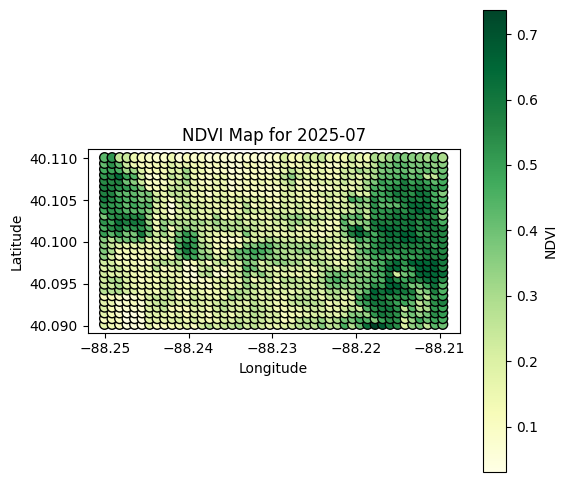

In [15]:
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt

# Path to your monthly CSV file
csv_file = "uiuc_ndvi_2025_07.csv"

# Load CSV
df = pd.read_csv(csv_file)

# Quick check
print(df.head())

# Scatter plot: longitude vs latitude, colored by NDVI
plt.figure(figsize=(6,6))
sc = plt.scatter(df['lon'], df['lat'], c=df['ndvi'], cmap='YlGn', s=50, edgecolor='k')
plt.colorbar(sc, label='NDVI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"NDVI Map for {df['year'][0]}-{df['month'][0]:02d}")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [16]:
import pandas as pd
import folium

# Load CSV
csv_file = "uiuc_ndvi_2025_07.csv"
df = pd.read_csv(csv_file)

# Approx grid size in degrees (~100m at 40° lat)
dx = 0.0009
dy = 0.0009

# Center map
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=16, tiles='cartodbpositron')

# Normalize NDVI for coloring
ndvi_min = df['ndvi'].min()
ndvi_max = df['ndvi'].max()

def ndvi_to_color(ndvi):
    if pd.isna(ndvi):
        return '#ffffff'
    green = int(255 * (ndvi - ndvi_min) / (ndvi_max - ndvi_min))
    return f'#00{green:02x}00'

# Add squares
for _, row in df.iterrows():
    lon = row['lon']
    lat = row['lat']
    color = ndvi_to_color(row['ndvi'])
    
    corners = [
        [lat - dy/2, lon - dx/2],
        [lat - dy/2, lon + dx/2],
        [lat + dy/2, lon + dx/2],
        [lat + dy/2, lon - dx/2]
    ]
    
    folium.Polygon(
        locations=corners,
        color=None,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"NDVI: {row['ndvi']:.3f}" if pd.notna(row['ndvi']) else "NDVI: None"
    ).add_to(m)

m.save("ndvi_map.html")
print("Map saved to ndvi_map.html")


Map saved to ndvi_map.html


In [17]:
df_clean = df
print(df['ndvi'].describe())

count    1380.000000
mean        0.287137
std         0.162557
min         0.030466
25%         0.157192
50%         0.235895
75%         0.411486
max         0.736848
Name: ndvi, dtype: float64


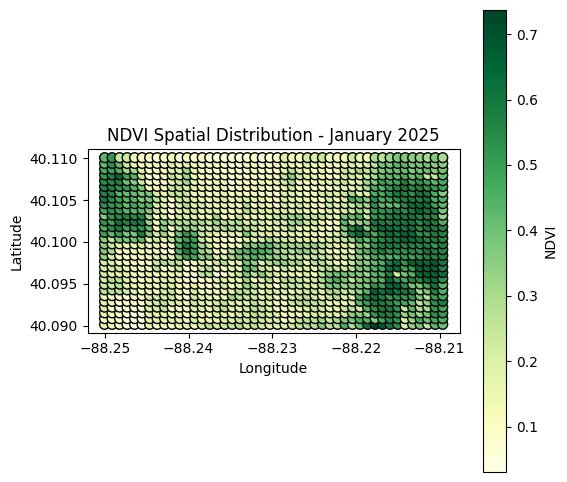

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(df_clean['lon'], df_clean['lat'], c=df_clean['ndvi'], cmap='YlGn', s=50, edgecolor='k')
plt.colorbar(label='NDVI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NDVI Spatial Distribution - January 2025')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [19]:
max_ndvi = df_clean.loc[df_clean['ndvi'].idxmax()]
min_ndvi = df_clean.loc[df_clean['ndvi'].idxmin()]

print(f"Greenest cell at (lat, lon): ({max_ndvi['lat']:.6f}, {max_ndvi['lon']:.6f}), NDVI={max_ndvi['ndvi']:.3f}")
print(f"Least green cell at (lat, lon): ({min_ndvi['lat']:.6f}, {min_ndvi['lon']:.6f}), NDVI={min_ndvi['ndvi']:.3f}")


Greenest cell at (lat, lon): (40.090141, -88.217705), NDVI=0.737
Least green cell at (lat, lon): (40.090828, -88.247349), NDVI=0.030


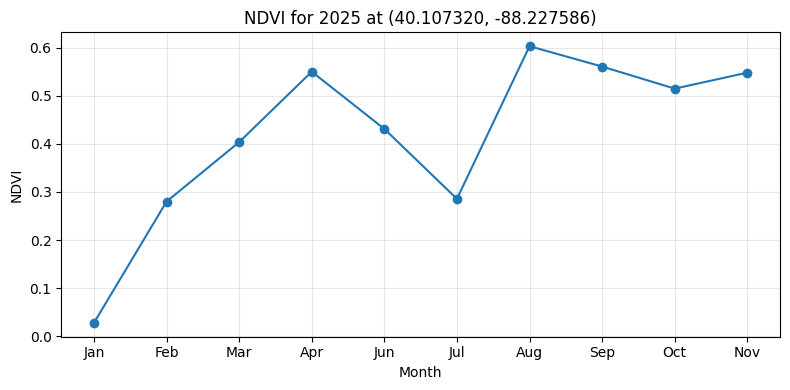

In [18]:
# ndvi_trends.py
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sqlite_path = "../data_collection/campus_data.db"   # adjust if needed
table_name = "vegetation_data"   # adjust if needed

def load_table(sqlite_path, table_name):
    conn = sqlite3.connect(sqlite_path)
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    conn.close()
    return df

def prepare_df(df):
    # Ensure numeric ndvi and lat/lon exist
    df = df.copy()
    # try to coerce ndvi numeric if string
    if 'ndvi' in df.columns:
        df['ndvi'] = pd.to_numeric(df['ndvi'], errors='coerce')
    # create datetime from year/month or date column
    if 'date' in df.columns and df['date'].notna().any():
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    else:
        # If year/month columns exist, build a date at month start
        if 'year' in df.columns and 'month' in df.columns:
            df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
        else:
            raise ValueError("No usable date. Provide 'date' or 'year' and 'month' columns.")
    return df

def find_nearest_cell_and_plot(df, target_lat, target_lon, savepath=None):
    # require lat/lon columns
    if ('lat' not in df.columns) or ('lon' not in df.columns):
        raise ValueError("Dataframe must contain 'lat' and 'lon' columns for cell lookup.")
    # compute squared distance
    df_coords = df.dropna(subset=['lat','lon','ndvi']).copy()
    df_coords['dist2'] = (df_coords['lat'] - target_lat)**2 + (df_coords['lon'] - target_lon)**2
    nearest = df_coords.loc[df_coords['dist2'].idxmin()]
    # get all records for that exact lat/lon
    lat0, lon0 = nearest['lat'], nearest['lon']
    cell_ts = df[(df['lat']==lat0) & (df['lon']==lon0)].dropna(subset=['ndvi']).copy()
    if cell_ts.empty:
        print("No NDVI records for nearest cell.")
        return
    cell_ts = cell_ts.sort_values('date')

    
    year_to_plot = 2025  # <-- change this to whichever year you want

    cell_ts_year = cell_ts[cell_ts['date'].dt.year == year_to_plot].copy()
    if cell_ts_year.empty:
        print(f"No data for {year_to_plot}.")
        return

    cell_ts_year['month_label'] = cell_ts_year['date'].dt.strftime('%b')  # Jan, Feb, ...

    plt.figure(figsize=(8,4))
    plt.plot(cell_ts_year['month_label'], cell_ts_year['ndvi'], marker='o', linestyle='-')
    plt.xlabel('Month')
    plt.ylabel('NDVI')
    plt.title(f'NDVI for {year_to_plot} at ({lat0:.6f}, {lon0:.6f})')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    df = load_table(sqlite_path, table_name)
    df = prepare_df(df)

    # 1) ROI monthly mean plot

    # 2) Example: plot nearest cell to a given coordinate
    target_lat = 40.107563
    target_lon = -88.227187
    find_nearest_cell_and_plot(df, target_lat, target_lon, savepath="nearest_cell_ts.png")


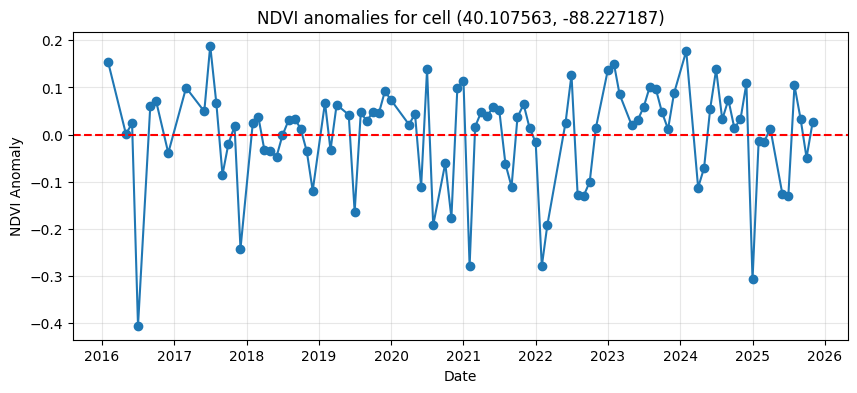

,year,month,lon,lat,ndvi,date
0,2016,2,-88.250044,40.090141,0.219326,2016-02-01
1,2016,2,-88.249146,40.090141,0.170829,2016-02-01
2,2016,2,-88.248248,40.090141,0.166667,2016-02-01
3,2016,2,-88.247349,40.090141,0.041677,2016-02-01
4,2016,2,-88.246451,40.090141,0.046090,2016-02-01


In [41]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Load data
sqlite_path = "../data_collection/campus_data.db"
table_name = "vegetation_data"
conn = sqlite3.connect(sqlite_path)
df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
conn.close()

# Ensure NDVI is numeric
df['ndvi'] = pd.to_numeric(df['ndvi'], errors='coerce')

# Create a datetime column from year/month (day=1)
df['date'] = pd.to_datetime(df[['year','month']].assign(day=1))

# Multi-year monthly mean per grid cell
monthly_mean = df.groupby(['lat','lon','month'])['ndvi'].mean().reset_index()
monthly_mean.rename(columns={'ndvi':'mean_ndvi'}, inplace=True)

# Compute anomalies
df_anomaly = df.merge(monthly_mean, on=['lat','lon','month'])
df_anomaly['ndvi_anomaly'] = df_anomaly['ndvi'] - df_anomaly['mean_ndvi']

# Example: plot anomalies for a single cell
target_lat, target_lon = 40.107563, -88.227187


df_anomaly['dist2'] = (df_anomaly['lat'] - target_lat)**2 + (df_anomaly['lon'] - target_lon)**2
nearest = df_anomaly.loc[df_anomaly['dist2'].idxmin()]

# Use the lat/lon of the nearest cell
lat0, lon0 = nearest['lat'], nearest['lon']

# Select all records for that nearest cell
cell = df_anomaly[(df_anomaly['lat']==lat0) & (df_anomaly['lon']==lon0)].sort_values(['year','month'])

#cell['month_label'] = cell['year'].astype(int).astype(str) + '-' + cell['month'].astype(int).astype(str).str.zfill(2)

plt.figure(figsize=(10,4))
plt.plot(cell['date'], cell['ndvi_anomaly'], marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('NDVI Anomaly')
plt.title(f'NDVI anomalies for cell ({target_lat}, {target_lon})')
plt.grid(alpha=0.3)
plt.show()
df.head()


In [ ]:
import folium
from folium import CircleMarker

# Compute multi-year mean NDVI per cell
avg_ndvi_cells = df.groupby(['lat','lon'])['ndvi'].mean().reset_index()

# Create Folium map centered on your ROI
m = folium.Map(location=[40.105, -88.225], zoom_start=14, tiles='cartodbpositron')

import matplotlib.colors as mcolors

# Normalize NDVI to 0-1
min_ndvi = avg_ndvi_cells['ndvi'].min()
max_ndvi = avg_ndvi_cells['ndvi'].max()

def ndvi_to_hex(ndvi):
    norm = (ndvi - min_ndvi) / (max_ndvi - min_ndvi)
    rgb = plt.cm.YlGn(norm)[:3]  # take only R,G,B, ignore alpha
    return mcolors.to_hex(rgb)

# Add circles to the map
for _, row in avg_ndvi_cells.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        fill=True,
        fill_opacity=0.8,
        color=None,
        fill_color=ndvi_to_hex(row['ndvi'])
    ).add_to(m)


# Save or display
m.save("avg_ndvi_map.html")
m
